# Signals, shapes, and convolutional neural networks
made by Sarah, with inspiration from Alfredo's demo https://youtu.be/eEzCZnOFU1w and notebook https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb

## Preliminaries

This is an excellent discussion of convolution as it pertains to CNNs:

http://colah.github.io/posts/2014-07-Conv-Nets-Modular/

This is additionally fun for the mathematically curious:

http://colah.github.io/posts/2014-07-Understanding-Convolutions/

And for the extremely curious:

http://colah.github.io/posts/2014-12-Groups-Convolution/

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib

Using matplotlib backend: agg


In [ ]:
import torch
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [ ]:
from PIL.Image import fromarray
from IPython import get_ipython


def display_np_arrays_as_images():
    """
    Utility function to render array values as pixels
    """
    def np_to_png(a):
        if 2 <= len(a.shape) <= 3:
            return fromarray(np.array(np.clip(a, 0, 1) * 255, dtype='uint8'))._repr_png_()
        else:
            return fromarray(np.zeros([1, 1], dtype='uint8'))._repr_png_()

    def np_to_text(obj, p, cycle):
        if len(obj.shape) < 2:
            print(repr(obj))
        if 2 <= len(obj.shape) <= 3:
            pass
        else:
            print('<array of shape {}>'.format(obj.shape))

    get_ipython().display_formatter.formatters['image/png'].for_type(np.ndarray, np_to_png)
    get_ipython().display_formatter.formatters['text/plain'].for_type(np.ndarray, np_to_text)

display_np_arrays_as_images()

In [ ]:
# function to count number of parameters
def get_n_params(model):
    np=0
    for p in list(model.parameters()):
        np += p.nelement()
    return np

In this demo we will use ```einops```, a wonderful library which provides a lucid, expressive, and above all uniform interface for tensor operations in numpy, pytorch, tf, and gluon (as someone who has to look up what function to use every time they want to change the shape of an array/tensor, this library is what I have always wanted). The shape of a tensor is always important and meaningful, but it is particularly conceptually notable when we work with models which use different operations and structures.

In [ ]:
!pip install einops
from einops import rearrange, reduce, repeat

# Comparing Convolutional and Fully Connected Layers

In [ ]:
input_size  = 28 * 28   # images are 28x28 pixels
output_size = 10      # there are 10 classes

# load MNIST
train_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=64, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    datasets.FashionMNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])),
    batch_size=1000, shuffle=True)

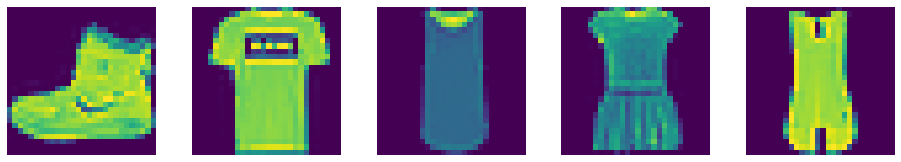

In [ ]:
# matplotlib rendering
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off');

In order for the images to be meaningful, we interpret and render them as two-dimensional signals:

In [ ]:
images, labels = iter(train_loader).next()
#images = images[:5]
print("batch shape:", images.shape)
b = images.shape[0]
c = images.shape[1]
h = images.shape[2]
w = images.shape[3]

out_dim = labels.unique().shape[0]

# for now we disregard channel = 1 by just multiplying it as 1 * one of the dimensions,
# as is usually done; turn rows = image height and cols = num images * image width
images_2d = rearrange(images, 'b c h w -> (c h) (b w)')

print("2d shape:", images_2d.shape)
images_2d.numpy()

batch shape: torch.Size([64, 1, 28, 28])
2d shape: torch.Size([28, 1792])


But in the fully connected networks we've used so far, we've transformed these 2D signals into 1D vectors first. This is what a batch looks like:

batch shape: torch.Size([64, 1, 28, 28])
1d shape: torch.Size([64, 784])


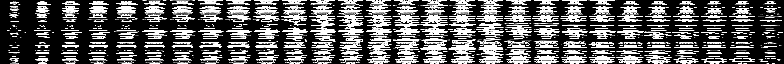

In [ ]:
images, labels = iter(train_loader).next()
print("batch shape:", images.shape)
images_1d = rearrange(images, 'b c h w -> b (c h w)')
print("1d shape:", images_1d.shape)
images_1d.numpy()

and these are our single images (rendered with matplotlib for separation):

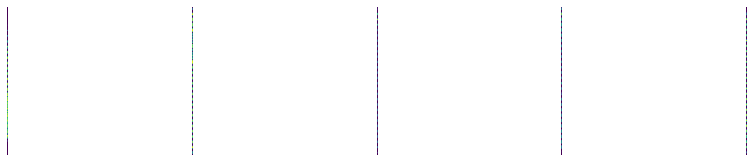

In [ ]:
plt.figure(figsize=(16, 6))
for i in range(5):
    plt.subplot(2, 5, i + 1)
    image, _ = train_loader.dataset.__getitem__(i)
    im_flat = rearrange(image, 'c h w -> (h w) c')
    plt.imshow(im_flat.numpy())
    plt.axis('off');

When we visualize the transformed versions, it becomes obvious that when our  linear layers are processing these samples, they are not being treated as images in the way we look at them.

With this in mind, we can compare the performance of the two types of networks on the classification task of labeling the images with the number they depict.

In [ ]:
class FC2Layer(torch.nn.Module):
    def __init__(self, b, c, h, w, out, n_hidden):
        super(FC2Layer, self).__init__()
        # linear input size
        self.input_size = h * w

        self.network = torch.nn.Sequential(
            torch.nn.Linear(input_size, n_hidden), 
            torch.nn.ReLU(), 
            torch.nn.Linear(n_hidden, n_hidden),
            torch.nn.ReLU(), 
            torch.nn.Linear(n_hidden, output_size), 
            torch.nn.LogSoftmax(dim=1)
        )

    def forward(self, x):
        # flatten the input image
        # x = x.view(-1, self.input_size)
        x = rearrange(x, 'b c h w -> b (c h w)')
        return self.network(x)

In [ ]:
def permute(data, perm):
    """
    Randomly permute the pixels of the image. This turns the two-dimensional
    signal into nonsense, but is not particularly noticed by the one-dimensional 
    signal.
    """
    b = data.shape[0]
    c = data.shape[1]
    h = data.shape[2]
    w = data.shape[3]

    flattened = rearrange(data, 'b c h w -> b (c h w)')
    #data.view(-1, 28*28)
    permuted = flattened[:, perm]
    #data = data[:, perm]
    # back to 2D
    permuted = rearrange(permuted, 'b (c h w) -> b c h w', c=c, h=h, w=w)
    #data = data.view(-1, 1, 28, 28)

    return permuted

In [ ]:
epochs = 10

def train(epoch, model, dataloader, perm=torch.arange(0, 784).long()): # .long() <-> to(torch.int64)
    model.train()
    for batch_idx, (data, target) in enumerate(dataloader):
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute pixels
        permuted = permute(data, perm)

        optimizer.zero_grad()
        output = model(permuted)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(permuted), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), loss.item()))
            
def test(model, dataloader, perm=torch.arange(0, 784).long()):
    num_batches = len(dataloader.dataset)

    model.eval()
    test_loss = 0
    correct = 0
    for data, target in dataloader:
        # send to device
        data, target = data.to(device), target.to(device)
        
        # permute the pixels
        permuted = permute(data, perm)

        output = model(permuted)
        test_loss += F.nll_loss(output, target, reduction='sum').item() # sum up batch loss                                                               
        pred = output.data.max(1, keepdim=True)[1] # get the index of the max log-probability                                                                 
        correct += pred.eq(target.data.view_as(pred)).cpu().sum().item()

    test_loss /= num_batches
    accuracy = 100. * correct / num_batches
    #accuracy_list.append(accuracy)
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, num_batches, accuracy))
    
    return accuracy

In [ ]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(b, c, h, w, out_dim, n_hidden)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

linear_accuracy = []
for epoch in range(epochs):
    train(epoch, model_fnn, train_loader)
    acc = test(model_fnn, test_loader)
    linear_accuracy.append(acc)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.300037
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.843786
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.314970
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.151491
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.832933
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.655216
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.713536
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.550177
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.704199
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.483463

Test set: Average loss: 0.6535, Accuracy: 7485/10000 (75%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.561604
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.522243
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.481085
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.506666
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.545945
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.497423
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.516859
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.466356
Train Epoch: 1 [51200/60

Next we will train a ConvNet with the same number of parameters. But before we make our convolutional neural network, let's take a moment to examine what convolutional layers in PyTorch do.

# Interlude: Signals, Channels, and Why Shapes Matter

First we will look at a 1D convolutional layer on a 1D signal, such as a time series of audio amplitude. We will assume that it is a stereophonic signal, in which case the number of channels will be 2:

In [ ]:
c_stereophonic = 2

We choose the number of kernels, and their size. The kernels will correspond to the number of learned parameters in the layer.

In [ ]:
num_kernels = 16
kernel_size = 3

conv1d = torch.nn.Conv1d(c_stereophonic, num_kernels, kernel_size)

In [ ]:
conv1d

Conv1d(2, 16, kernel_size=(3,), stride=(1,))

We can now look at the size of the weight tensor for our layer. Its dimensions are organized as [kernels, channels, kernel size].

In [ ]:
conv1d.weight.size()

torch.Size([16, 2, 3])

In [ ]:
print(conv1d.bias.shape) # one bias per kernel

torch.Size([16])


We make a random signal to show how the shapes need to be specified:

In [ ]:
batch_size = 1
num_samples = 64
audio = torch.randn(batch_size, c_stereophonic, num_samples)
print(audio.shape)

torch.Size([1, 2, 64])


Let's find out what is the output when we apply the convolution to our input signal:

In [ ]:
out = conv1d(audio)
print(out.shape) # batch, channels, length of signal (n - k + 1)

torch.Size([1, 16, 62])


We see that the convolution layer has changed the shape of our input, such that the batch size is still the same, but the output channels are now transformed into the number of kernels, and the length of the signal has been reduced according to $(n - k + 1)$, where $n$ is the original number of samples, and $k$ is the size of the kernel.

We can try a differently sized kernel:

In [ ]:
kernel_size = 5
conv_ksize5 = torch.nn.Conv1d(c_stereophonic, num_kernels, kernel_size)

In [ ]:
conv_ksize5(audio).size()

torch.Size([1, 16, 60])

Next we'll try a 2D layer on a 2D signal, such as an image. To mix it up a bit, we'll pretend it is a hyperspectral image, which has 20 channels.

In [ ]:
# signal: 1 image, 20 channels, 64 x 128 pixels
batch_size = 1
c_hyperspectral = 20
height = 64
width = 128
image = torch.rand(num_samples, c_hyperspectral, height, width)
print(image.shape)

torch.Size([64, 20, 64, 128])


2D signals require 2D kernels. In reference to images, the number of kernels may also be referred to as the number of features, since it is often considered to be an extraction of fewer features from the original image signal.

In [ ]:
num_kernels2d = 16
kernel_size2d = torch.Size([3, 5])
conv2d = torch.nn.Conv2d(c_hyperspectral, num_kernels2d,
                   kernel_size2d)

In [ ]:
print(conv2d.weight.size())
# kernels, channels, kernel size (treated as height and width dimensions in the tensor)
# n.b.: the number of dimensions required to store kernels
# when performing 2d convolutions = 4 (2 kernels * 2 signal dimensions)

torch.Size([16, 20, 3, 5])


The same size-reduction effect now occurs in each of the two dimensions.

In [ ]:
print(conv2d(image).size())
# batch size, channels, len(signal) = (h - ksize + 1, w - ksize + 1)

torch.Size([64, 16, 62, 124])


In applications this is generally compensated for by "padding," which is the insertion of a number of extra samples on the edges of the signal, often just filled with zeros, sometimes chosen to be the last values on the other end of the signal, as if it wraps around (there are philosophical arguments for and against this considering what it means to assume that the continuation of the edges of your signal is either null or periodic, but that's beyond our scope for now). For a kernel of size (3, 5) we choose padding of (1, 2) - in PyTorch, the default is zero-padding.

In [ ]:
stride2d = 1
padding = torch.Size([1, 2])
conv2d_padded = torch.nn.Conv2d(c_hyperspectral, num_kernels2d,
                          kernel_size2d, stride2d, padding)

In [ ]:
conv2d_padded.weight.size()

torch.Size([16, 20, 3, 5])

In [ ]:
conv2d_padded(image).size()

torch.Size([64, 16, 64, 128])

# Back to our CNN

In [ ]:
class CNN(torch.nn.Module):
    def __init__(self, b, c, h, w, output_size, num_kernels):
        super(CNN, self).__init__()

        self.num_kernels = num_kernels
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=num_kernels, 
                                     kernel_size=5)
        self.conv2 = torch.nn.Conv2d(num_kernels, num_kernels, kernel_size=5)

        self.fc1 = torch.nn.Linear(num_kernels * 4 * 4, 50)
        self.fc2 = torch.nn.Linear(50, output_size)
        
    def forward(self, x, verbose=False):
        x = self.conv1(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = rearrange(x, 'b c h w -> b (c h w)')
        #x = x.view(-1, self.num_kernels*4*4)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.log_softmax(x, dim=1)
        return x

In [ ]:
num_kernels = 6 # number of feature maps

model_cnn = CNN(b, c, h, w, out_dim, num_kernels)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

cnn_accuracy = []
for epoch in range(epochs):
    train(epoch, model_cnn, train_loader)
    acc = test(model_cnn, test_loader)
    cnn_accuracy.append(acc)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.330113
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.104932
Train Epoch: 0 [12800/60000 (21%)]	Loss: 0.759088
Train Epoch: 0 [19200/60000 (32%)]	Loss: 0.770365
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.795407
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.841887
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.645564
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.660899
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.756294
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.749314

Test set: Average loss: 0.6534, Accuracy: 7489/10000 (75%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.602908
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.530118
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.716943
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.520057
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.514017
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.561685
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.592258
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.358238
Train Epoch: 1 [51200/60

The ConvNet performs better with the same number of parameters, thanks to its use of prior knowledge about images as two-dimensional signals. In flattening an image tensor, we are removing an important property of the signal - the property of locality. When we use convolutional layers instead of fully-connected layers, we preserve that property, and the transformations we make on the signals become more meaningful.

- The use of convolution preserves locality and stationarity in images
- The use of pooling builds in some translation invariance


# What happens when we permute the pixels?

If we consider the image to be a 2D signal with local relationships among each sample, permuting the image turns it into nonsense, and intuitively it should be harder to classify.

In [ ]:
permutation = torch.randperm(784)

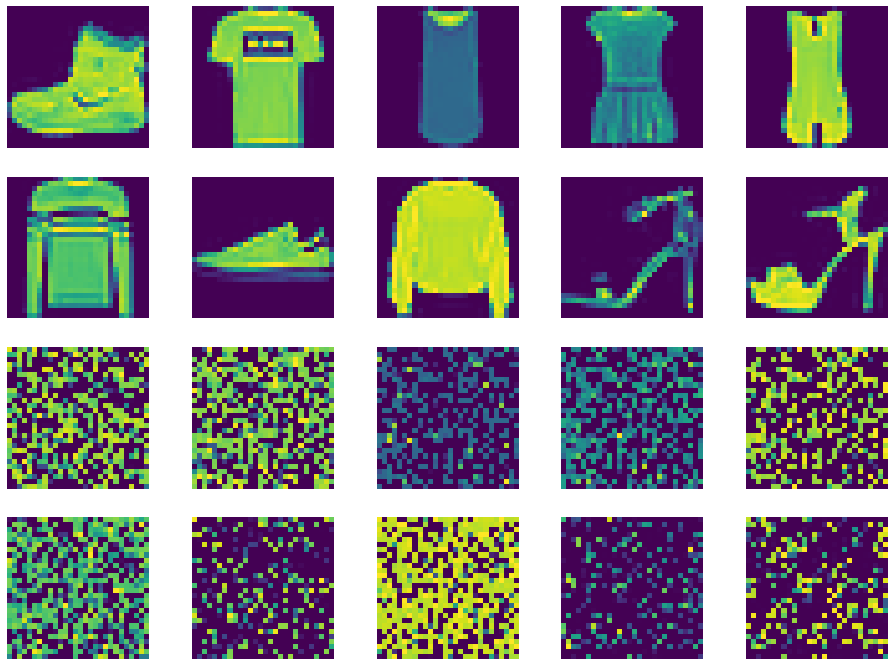

In [ ]:
plt.figure(figsize=(16, 12))
for i in range(10):
    image, _ = train_loader.dataset.__getitem__(i)

    # permute pixels
    permuted = rearrange(image, 'c h w -> () (c h w)')
    #image_perm = image.view(-1, 28*28).clone()
    image_perm = permuted[:, permutation]
    image_ = rearrange(image_perm, 'c (h w) -> h (w c)', h=h, w=w)
    #image_perm = image_perm.view(-1, 1, 28, 28)

    plt.subplot(4, 5, i + 1)
    plt.imshow(image.squeeze().numpy())
    plt.axis('off')
    plt.subplot(4, 5, i + 11)
    plt.imshow(image_.numpy())
    plt.axis('off')

Our batch is now this:

In [ ]:
batch, labels = iter(train_loader).next()
permuted_batch = permute(batch, permutation)
permuted_batch = rearrange(permuted_batch, 'b c h w -> (h c) (b w)')
permuted_batch.numpy()

Nice and noisy. Now let us see what our networks can do with this.

### ConvNet

In [ ]:
# Training settings 
num_kernels = 6 # number of feature maps

model_cnn = CNN(b, c, h, w, out_dim, num_kernels)
model_cnn.to(device)
optimizer = optim.SGD(model_cnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_cnn)))

lin_permuted_acc = []
for epoch in range(epochs):
    train(epoch, model_cnn, train_loader, permutation)
    acc = test(model_cnn, test_loader, permutation)
    lin_permuted_acc.append(acc)

Number of parameters: 6422
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.290800
Train Epoch: 0 [6400/60000 (11%)]	Loss: 2.235440
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.942070
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.007720
Train Epoch: 0 [25600/60000 (43%)]	Loss: 0.819803
Train Epoch: 0 [32000/60000 (53%)]	Loss: 0.853927
Train Epoch: 0 [38400/60000 (64%)]	Loss: 0.908475
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.554577
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.655472
Train Epoch: 0 [57600/60000 (96%)]	Loss: 0.609659

Test set: Average loss: 0.6594, Accuracy: 7575/10000 (76%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 0.487425
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.692080
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.676329
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.515568
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.577033
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.674639
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.460700
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.562531
Train Epoch: 1 [51200/60

### Fully Connected

In [ ]:
n_hidden = 8 # number of hidden units

model_fnn = FC2Layer(b, c, h, w, out_dim, n_hidden)
model_fnn.to(device)
optimizer = optim.SGD(model_fnn.parameters(), lr=0.01, momentum=0.5)
print('Number of parameters: {}'.format(get_n_params(model_fnn)))

cnn_permuted_acc = []
for epoch in range(epochs):
    train(epoch, model_fnn, train_loader, permutation)
    acc = test(model_fnn, test_loader, permutation)
    cnn_permuted_acc.append(acc)

Number of parameters: 6442
Train Epoch: 0 [0/60000 (0%)]	Loss: 2.280632
Train Epoch: 0 [6400/60000 (11%)]	Loss: 1.918609
Train Epoch: 0 [12800/60000 (21%)]	Loss: 1.802273
Train Epoch: 0 [19200/60000 (32%)]	Loss: 1.623985
Train Epoch: 0 [25600/60000 (43%)]	Loss: 1.056991
Train Epoch: 0 [32000/60000 (53%)]	Loss: 1.075294
Train Epoch: 0 [38400/60000 (64%)]	Loss: 1.216644
Train Epoch: 0 [44800/60000 (75%)]	Loss: 0.985226
Train Epoch: 0 [51200/60000 (85%)]	Loss: 0.865871
Train Epoch: 0 [57600/60000 (96%)]	Loss: 1.049024

Test set: Average loss: 0.8500, Accuracy: 6796/10000 (68%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 1.070727
Train Epoch: 1 [6400/60000 (11%)]	Loss: 0.788890
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.829134
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.891679
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.849708
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.764072
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.703011
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.637965
Train Epoch: 1 [51200/60

The ConvNet's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same.

The ConvNet makes the assumption that neighboring pixels have a relationship based on their proximity in 2D space and uses this as additional information, increasing its accuracy. The fully-connected network does not make this assumption. It does not perform as well when the assumption is true, since it doesn't take advantage of this prior knowledge, but it also doesn't suffer when the assumption is wrong.

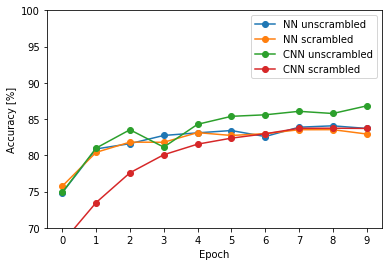

In [ ]:
fig, ax = plt.subplots()

accuracies = [linear_accuracy, lin_permuted_acc, cnn_accuracy,cnn_permuted_acc]
plot_labels = ['NN unscrambled', 'NN scrambled', 'CNN unscrambled',
         'CNN scrambled']

for acc, l in zip(accuracies, plot_labels):
    ax.plot(range(epochs), acc, label=l, marker='o')

plt.ylim((70, 100))
plt.xticks(range(epochs), labels=[str(i) for i in range(epochs)])
plt.xlabel('Epoch')
plt.ylabel('Accuracy [%]')
plt.legend(plot_labels)
fig.show()